Summary of Valuation Metrics and Standardized Scores:
Ticker Market                 Sector         PE        PB        PS  EV_EBITDA      z_PE      z_PB      z_PS  z_EV_EBITDA  Composite_Z
    WB  China Communication Services   7.905173  0.626580  1.313997      3.235  1.681267  0.542198  0.253670     0.612099     0.772308
  BIDU  China Communication Services   9.900772  0.117674  0.233022      6.072  1.313894  0.726199  0.634896     0.410265     0.771314
  BILI  China Communication Services        NaN  0.564823  0.295737     -3.630       NaN  0.564527  0.612779     1.100499     0.759268
  INTC     US             Technology        NaN  0.978365  1.841924     17.476       NaN  0.816779  1.165292     0.264757     0.748942
  QCOM     US             Technology  15.039913  5.733437  3.789034     12.267  1.121335  0.435861  0.766367     0.411365     0.683732
    ZM     US             Technology  22.819315  2.506501  4.792350     15.610  0.763763  0.694363  0.560808     0.317276     0.584052
 

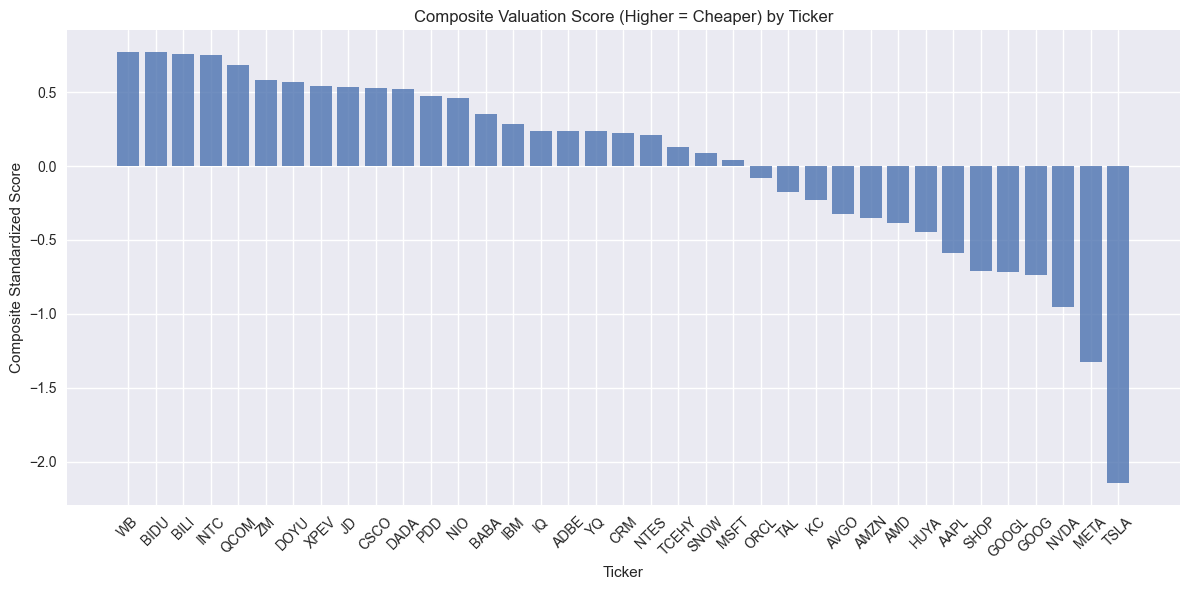

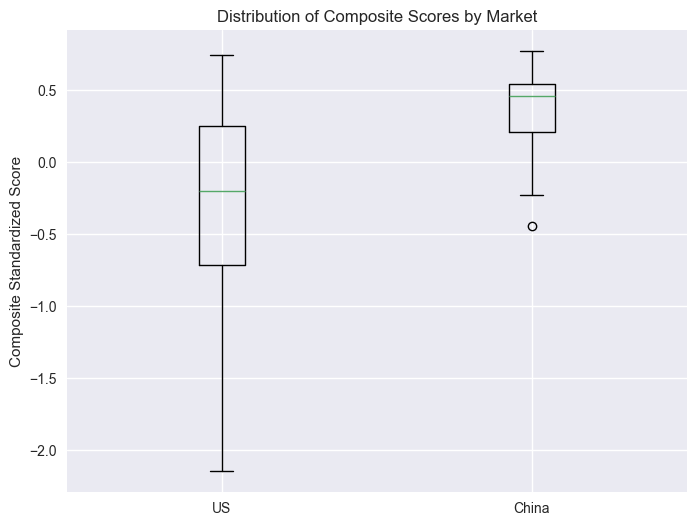

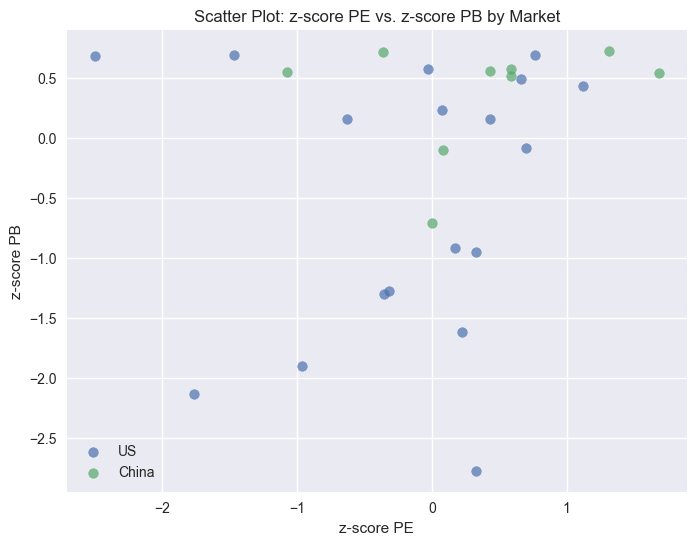

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1) Define ticker lists for US and Chinese tech stocks.
# -------------------------------
us_tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "META", "NVDA",
    "TSLA", "AMD", "IBM", "ORCL", "INTC", "CSCO", "CRM", "ADBE",
    "QCOM", "AVGO", "ZM", "SNOW", "SHOP"
]

china_tickers = [
    "BABA", "JD", "BIDU", "PDD", "TCEHY", "NTES", "IQ", "XPEV",
    "NIO", "WB", "HUYA", "DADA", "YQ", "TAL", "DOYU", "KC", "BILI"
]

# -------------------------------
# 2) Helper function to fetch live valuation metrics and sector.
#    The four key metrics are: PE, PB, PS, EV/EBITDA.
# -------------------------------
def get_valuation_metrics(ticker):
    try:
        ticker_obj = yf.Ticker(ticker)
        info = ticker_obj.info  # live data from Yahoo Finance
        return {
            "Ticker": ticker,
            "Sector": info.get("sector", "Unknown"),
            "PE": info.get("trailingPE", np.nan),
            "PB": info.get("priceToBook", np.nan),
            "PS": info.get("priceToSalesTrailing12Months", np.nan),
            "EV_EBITDA": info.get("enterpriseToEbitda", np.nan)
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

# -------------------------------
# 3) Fetch data for each ticker (live, no extra files needed).
# -------------------------------
us_data = [get_valuation_metrics(t) for t in us_tickers]
us_data = [d for d in us_data if d is not None]
df_us = pd.DataFrame(us_data)
df_us["Market"] = "US"  # Mark the market

china_data = [get_valuation_metrics(t) for t in china_tickers]
china_data = [d for d in china_data if d is not None]
df_china = pd.DataFrame(china_data)
df_china["Market"] = "China"  # Mark the market

# Combine both markets into one DataFrame for later comparisons.
df_all = pd.concat([df_us, df_china], ignore_index=True)

# -------------------------------
# 4) Compute standardized (z-score) evaluation for each key metric.
#    We compute the z-score within each sector group.
#    Note: Since for valuation metrics a lower number is better,
#          we invert the z-score (multiply by -1) so that higher scores imply cheaper valuations.
# -------------------------------
key_metrics = ["PE", "PB", "PS", "EV_EBITDA"]

def compute_inverted_z(x):
    # Use standard deviation if > 0, otherwise default to 1 to avoid division by zero.
    std = x.std() if x.std() > 0 else 1
    return -(x - x.mean()) / std

for metric in key_metrics:
    df_all[f'z_{metric}'] = df_all.groupby("Sector")[metric].transform(compute_inverted_z)

# -------------------------------
# 5) Compute composite standardized score as the mean of the available z-scores.
# -------------------------------
z_cols = [f'z_{m}' for m in key_metrics]
df_all['Composite_Z'] = df_all[z_cols].mean(axis=1, skipna=True)

# -------------------------------
# 6) Display summary table
# -------------------------------
summary_cols = ["Ticker", "Market", "Sector"] + key_metrics + z_cols + ["Composite_Z"]
print("Summary of Valuation Metrics and Standardized Scores:")
print(df_all[summary_cols].sort_values("Composite_Z", ascending=False).to_string(index=False))

# -------------------------------
# 7) Visualization
# -------------------------------
# 7.1 Bar chart: Composite standardized score by ticker (grouped by market)
plt.figure(figsize=(12,6))
# Sort stocks by composite score for plotting
df_plot = df_all.sort_values("Composite_Z", ascending=False)
bars = plt.bar(df_plot["Ticker"], df_plot["Composite_Z"], alpha=0.8)
plt.xlabel("Ticker")
plt.ylabel("Composite Standardized Score")
plt.title("Composite Valuation Score (Higher = Cheaper) by Ticker")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7.2 Boxplot: Composite score distribution by Market
plt.figure(figsize=(8,6))
markets = df_all["Market"].unique()
data = [df_all[df_all["Market"] == m]["Composite_Z"].dropna() for m in markets]
plt.boxplot(data, labels=markets)
plt.ylabel("Composite Standardized Score")
plt.title("Distribution of Composite Scores by Market")
plt.show()

# 7.3 Scatter plot: z_PE vs z_PB colored by Market
plt.figure(figsize=(8,6))
for market in df_all["Market"].unique():
    subset = df_all[df_all["Market"] == market]
    plt.scatter(subset["z_PE"], subset["z_PB"], label=market, alpha=0.7)
plt.xlabel("z-score PE")
plt.ylabel("z-score PB")
plt.title("Scatter Plot: z-score PE vs. z-score PB by Market")
plt.legend()
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sum/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/dm/sn7k0w417sx5wmqxcnb4c5fw0000gn/T/ipykernel_4066/1129795445.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')


/var/folders/dm/sn7k0w417sx5wmqxcnb4c5fw0000gn/T/ipykernel_4066/1129795445.py:102: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




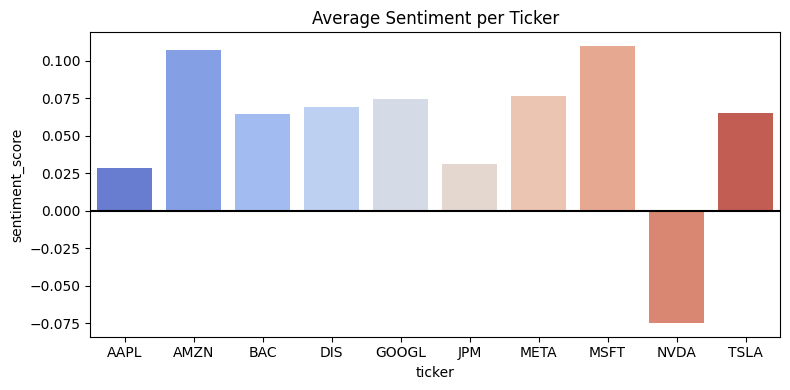

/var/folders/dm/sn7k0w417sx5wmqxcnb4c5fw0000gn/T/ipykernel_4066/1129795445.py:110: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




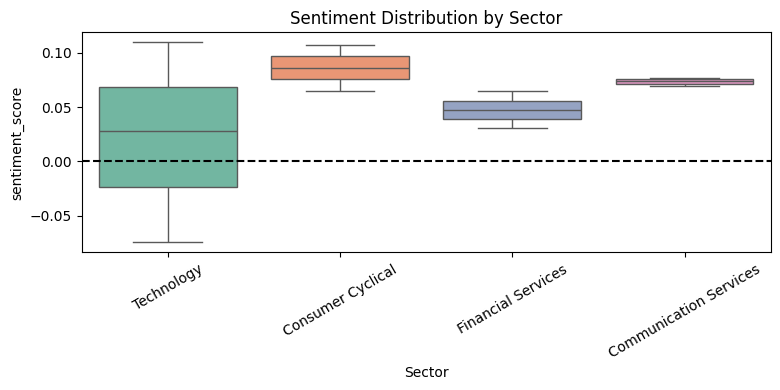

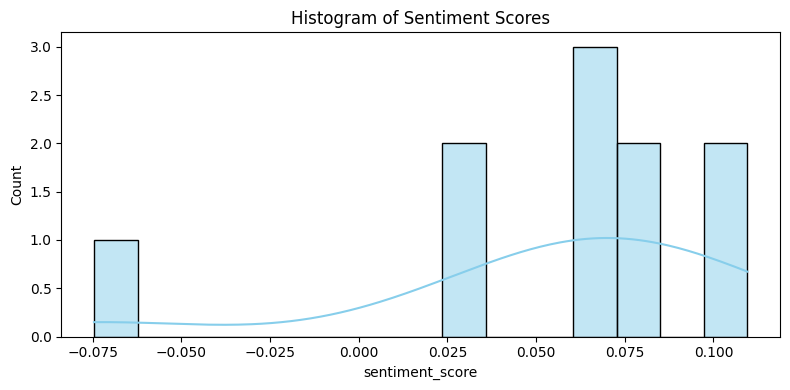

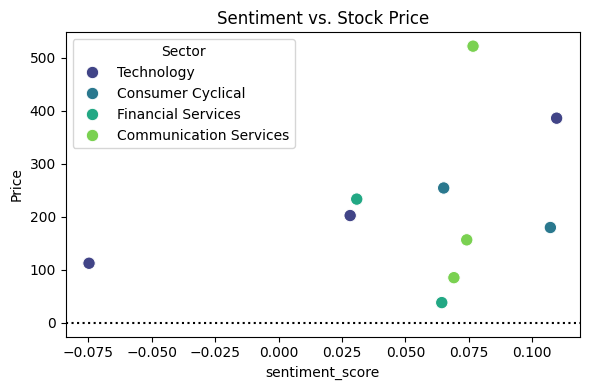

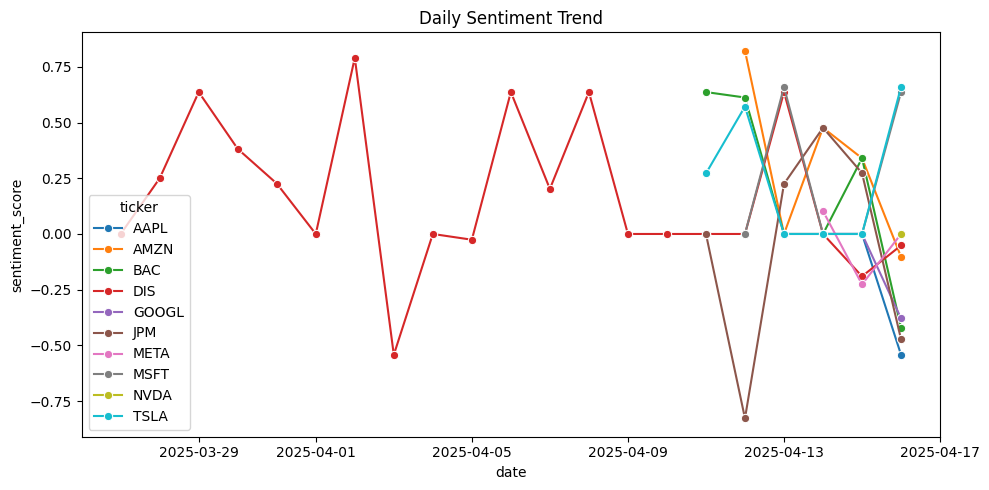

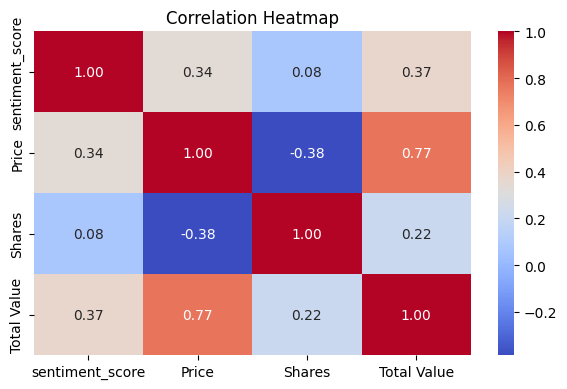

In [1]:
%matplotlib inline
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from bs4 import BeautifulSoup
from datetime import datetime

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import yfinance as yf

# 1. Define ticker symbols and number of shares
tickers_dict = {
    'AAPL': 6, 'MSFT': 5, 'GOOGL': 3, 'AMZN': 5, 'TSLA': 1,
    'META': 3, 'NVDA': 4, 'JPM': 3, 'BAC': 5, 'DIS': 8
}
tickers = list(tickers_dict.keys())
shares = list(tickers_dict.values())

# 2. Fetch news data from FinViz
news_tables = {}
for ticker in tickers:
    try:
        url = f"https://finviz.com/quote.ashx?t={ticker}"
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        news_tables[ticker] = soup.find(id='news-table')
    except Exception as e:
        print(f"Could not fetch news for {ticker}: {e}")

# 3. Parse news headlines
all_news = []
for ticker, news_table in news_tables.items():
    if news_table:
        for row in news_table.findAll('tr'):
            if row.a:
                headline = row.a.get_text()
                date_info = row.td.text.split()
                # If only time is available, use the previous date (or leave it empty)
                if len(date_info) == 1:
                    date_str, time_str = None, date_info[0]
                else:
                    date_str, time_str = date_info[0], date_info[1]
                all_news.append([ticker, date_str, time_str, headline])

news_df = pd.DataFrame(all_news, columns=['ticker', 'date', 'time', 'headline'])

# 4. Perform sentiment analysis
sid = SentimentIntensityAnalyzer()
news_df['sentiment_score'] = news_df['headline'].apply(
    lambda x: sid.polarity_scores(x)['compound'] if x else 0
)
# Try converting date format, errors become NaT
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
avg_sentiment = news_df.groupby('ticker')['sentiment_score'].mean().reset_index()

# 5. Get basic stock information
sectors, industries, prices = [], [], []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        sectors.append(info.get('sector', 'Unknown'))
        industries.append(info.get('industry', 'Unknown'))
        prices.append(info.get('regularMarketPreviousClose', None))
    except Exception as e:
        print(f"Could not fetch metadata for {ticker}: {e}")
        sectors.append("Unknown")
        industries.append("Unknown")
        prices.append(None)

meta_df = pd.DataFrame({
    'ticker': tickers,
    'Sector': sectors,
    'Industry': industries,
    'Price': prices,
    'Shares': shares
})
meta_df['Total Value'] = meta_df['Price'] * meta_df['Shares']
final_df = avg_sentiment.merge(meta_df, on='ticker')

# 6. Interactive Treemap (using Plotly with hover effect)
treemap_fig = px.treemap(
    final_df,
    path=[px.Constant("Sectors"), 'Sector', 'Industry', 'ticker'],
    values='Total Value',
    color='sentiment_score',
    hover_data=['Price', 'sentiment_score'],
    color_continuous_scale=['#FF0000', '#000000', '#00FF00'],
    color_continuous_midpoint=0
)
treemap_fig.update_layout(title="Treemap: Sentiment vs. Portfolio Value")
treemap_fig.show()

# 7. Bar chart: average sentiment score for each stock
plt.figure(figsize=(8, 4))
sns.barplot(x='ticker', y='sentiment_score', data=final_df, palette='coolwarm')
plt.axhline(0, color='black')
plt.title("Average Sentiment per Ticker")
plt.tight_layout()
plt.show()

# 8. Boxplot: sentiment score distribution by sector
plt.figure(figsize=(8, 4))
sns.boxplot(x='Sector', y='sentiment_score', data=final_df, palette='Set2')
plt.axhline(0, color='black', linestyle='--')
plt.title("Sentiment Distribution by Sector")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 9. Histogram: overall sentiment score distribution
plt.figure(figsize=(8, 4))
sns.histplot(final_df['sentiment_score'], kde=True, color='skyblue', bins=15)
plt.title("Histogram of Sentiment Scores")
plt.tight_layout()
plt.show()

# 10. Scatter plot: sentiment score vs. stock price
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=final_df,
    x='sentiment_score',
    y='Price',
    hue='Sector',
    palette='viridis',
    s=80
)
plt.title("Sentiment vs. Stock Price")
plt.axhline(y=0, color='black', linestyle=':')
plt.tight_layout()
plt.show()

# 11. Line chart: daily sentiment trend
news_time_df = news_df.dropna(subset=['date'])
daily_sentiment = news_time_df.groupby(['ticker', 'date'])['sentiment_score'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_sentiment, x='date', y='sentiment_score', hue='ticker', marker="o")
plt.title("Daily Sentiment Trend")
plt.tight_layout()
plt.show()

# 12. Heatmap: correlation between variables
corr_data = final_df[['sentiment_score', 'Price', 'Shares', 'Total Value']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()
